<a href="https://colab.research.google.com/github/bahgat-ahmed/Natural-Language-Processing-in-TensorFlow/blob/main/Course_3_Week_3_Lesson_2_Comparing_LSTM_GRU_%26_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.3.0


In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLIFYO0/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLIFYO0/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLIFYO0/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

# Using GRU

In [7]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 50
history1 = model1.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 18s 23ms/step - loss: 0.5130 - accuracy: 0.7188 - val_loss: 0.3675 - val_accuracy: 0.8403
Epoch 2/50
782/782 [==============================] - 17s 22ms/step - loss: 0.3041 - accuracy: 0.8766 - val_loss: 0.3594 - val_accuracy: 0.8464
Epoch 3/50
782/782 [==============================] - 17s 22ms/step - loss: 0.2330 - accuracy: 0.9099 - val_loss: 0.3828 - val_accuracy: 0.8368
Epoch 4/50
782/782 [==============================] - 17s 22ms/step - loss: 0.1764 - accuracy: 0.9355 - val_loss: 0.4377 - val_accuracy: 0.8260
Epoch 5/50
782/782 [==============================] - 17s 22ms/step - loss: 0.1290 - accuracy: 0.9547 - val_loss: 0.4954 - val_accuracy: 0.8320
Epoch 6/50
782/782 [==============================] - 17s 22ms/step - loss: 0.0845 - accuracy: 0.9713 - val_loss: 0.5417 - val_accuracy: 0.8180
Epoch 7/50
782/782 [==============================] - 17s 22ms/step - loss: 0.0578 - accuracy: 0.9812 - val_loss: 0.7271 - val_accuracy:

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

NameError: ignored

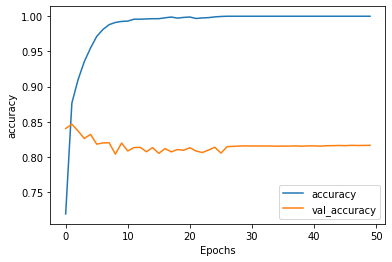

In [11]:
plot_graphs(history1, 'accuracy')

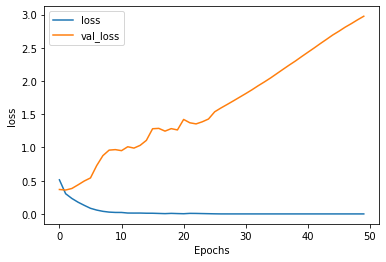

In [12]:
plot_graphs(history1, 'loss')

# Using LSTM

In [13]:
# Model Definition with LSTM
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_epochs = 50
history2 = model2.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 18s 23ms/step - loss: 0.4863 - accuracy: 0.7542 - val_loss: 0.3799 - val_accuracy: 0.8370
Epoch 2/50
782/782 [==============================] - 17s 22ms/step - loss: 0.3057 - accuracy: 0.8794 - val_loss: 0.3657 - val_accuracy: 0.8404
Epoch 3/50
782/782 [==============================] - 17s 22ms/step - loss: 0.2488 - accuracy: 0.9057 - val_loss: 0.3837 - val_accuracy: 0.8326
Epoch 4/50
782/782 [==============================] - 17s 22ms/step - loss: 0.2131 - accuracy: 0.9216 - val_loss: 0.4145 - val_accuracy: 0.8335
Epoch 5/50
782/782 [==============================] - 18s 23ms/step - loss: 0.1642 - accuracy: 0.9421 - val_loss: 0.4527 - val_accuracy: 0.8305
Epoch 6/50
782/782 [==============================] - 18s 22ms/step - loss: 0.1265 - accuracy: 0.9584 - val_loss: 0.4963 - val_accuracy: 0.8256
Epoch 7/50
782/782 [==============================] - 18s 23ms/step - loss: 0.0981 - accuracy: 0.9692 - val_loss: 0.5470 - val_accuracy:

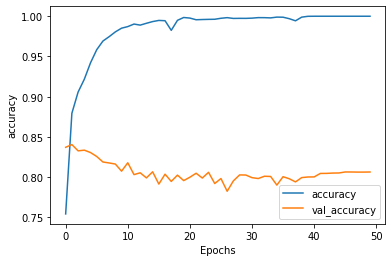

In [15]:
plot_graphs(history2, 'accuracy')

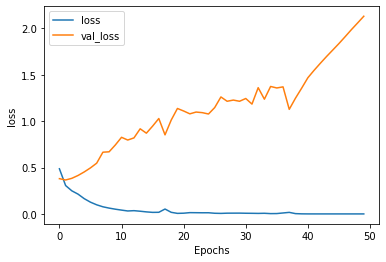

In [16]:
plot_graphs(history2, 'loss')

# Using Conv1D

Another type of layer that you can use is a convolution, in a very similar way to what you did with images. The code to use a convolution on network is here. It's very similar to what you had before. You specify the number of convolutions that you want to learn, their size, and their activation function. We have 128 filters each for 5 words. The effect of this will then be the same. Now words will be grouped into the size of the filter in this case 5. And convolutions will learned that can map the word classification to the desired output.

In [19]:
# Model Definition with Conv1D
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

If we go back to the model and explore the parameters, we'll see that we have 128 filters each for 5 words. And an exploration of the model will show these dimensions. As the size of the input was 120 words, and a filter that is 5 words long will shave off 2 words from the front and back, leaving us with 116. The 128 filters that we specified will show up here as part of the convolutional layer.

In [20]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epochs = 50
history3 = model3.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 7s 9ms/step - loss: 0.4688 - accuracy: 0.7547 - val_loss: 0.3493 - val_accuracy: 0.8478
Epoch 2/50
782/782 [==============================] - 7s 9ms/step - loss: 0.2874 - accuracy: 0.8803 - val_loss: 0.3545 - val_accuracy: 0.8457
Epoch 3/50
782/782 [==============================] - 7s 9ms/step - loss: 0.2353 - accuracy: 0.9071 - val_loss: 0.3773 - val_accuracy: 0.8401
Epoch 4/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1977 - accuracy: 0.9255 - val_loss: 0.4132 - val_accuracy: 0.8338
Epoch 5/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1701 - accuracy: 0.9369 - val_loss: 0.4502 - val_accuracy: 0.8272
Epoch 6/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1411 - accuracy: 0.9513 - val_loss: 0.4953 - val_accuracy: 0.8225
Epoch 7/50
782/782 [==============================] - 7s 9ms/step - loss: 0.1178 - accuracy: 0.9604 - val_loss: 0.5505 - val_accuracy: 0.8164
Epoch 

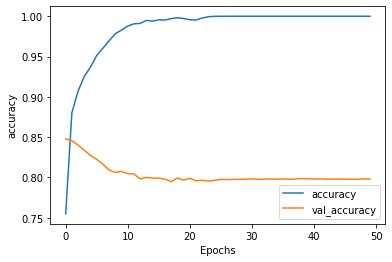

In [22]:
plot_graphs(history3, 'accuracy')

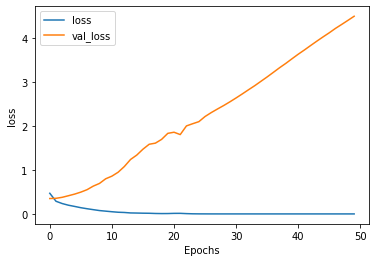

In [23]:
plot_graphs(history3, 'loss')

Saving the built models

In [24]:
model1.save("test1.h5")

In [25]:
model2.save("test2.h5")

In [26]:
model3.save("test3.h5")

Remember that with text, you'll probably get a bit more overfitting than you would have done with images. Not least because you'll almost always have out of vocabulary words in the validation data set. That is words in the validation dataset that weren't present in the training, naturally leading to overfitting. These words can't be classified and, of course, you're going to have these overfitting issues, but see what you can do to avoid them.